# Example 04: Choosing Your Model Architecture

TSFast supports three model families for time series system identification:

- **RNNs** (LSTM, GRU) -- sequential memory, processing one timestep at a time
- **TCNs** -- parallel causal convolutions with exponentially growing receptive field
- **CRNNs** -- hybrid combining CNN feature extraction with RNN sequential modeling

This example trains each architecture on the same dataset and compares their
performance and trade-offs.

## Prerequisites

This example builds on concepts from Examples 00-02. Make sure you have
completed those first.

## Setup

In [1]:
from tsfast.datasets.benchmark import create_dls_silverbox
from tsfast.models.rnn import RNNLearner
from tsfast.models.cnn import TCNLearner, CRNNLearner
from tsfast.learner.losses import fun_rmse

## Load the Dataset

We use the Silverbox benchmark for a fair comparison. All four models train on
exactly the same data and are evaluated on the same validation set.

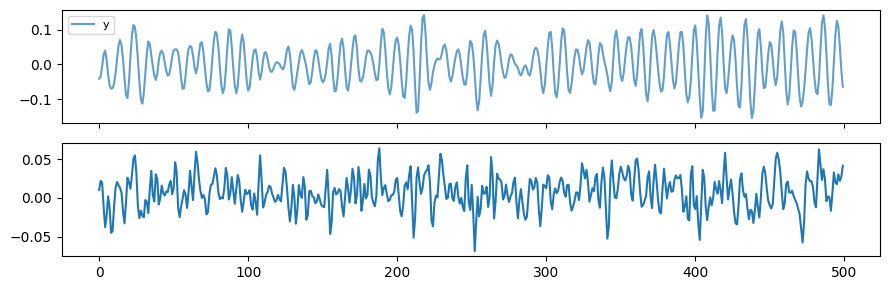

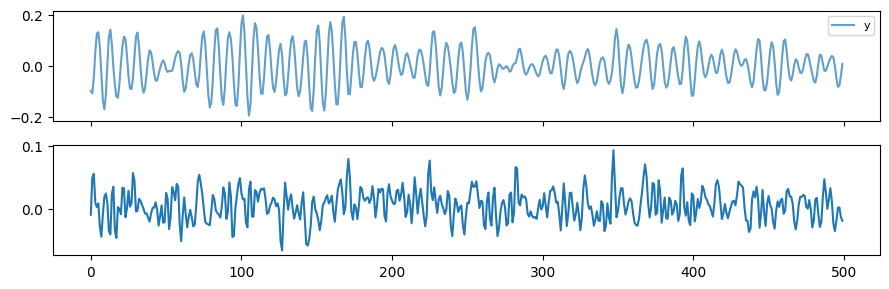

In [2]:
dls = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)
dls.show_batch(max_n=2)

## LSTM

Long Short-Term Memory: processes the sequence step-by-step, maintaining a
cell state and hidden state at each timestep. The gating mechanism (input,
forget, output gates) allows it to selectively remember or discard information,
making it effective at capturing long-range dependencies.

Key parameter:

- **`hidden_size=40`** -- dimension of the hidden state vector. Larger values
  give the model more capacity to represent complex dynamics, but increase
  memory usage and training time.

In [3]:
lrn_lstm = RNNLearner(dls, rnn_type='lstm', hidden_size=40, metrics=[fun_rmse])
lrn_lstm.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.006243,0.006132,0.010967,00:02
1,0.004373,0.003705,0.009676,00:02
2,0.004902,0.004491,0.009960,00:02
3,0.004231,0.005178,0.010122,00:02
4,0.004444,0.003978,0.009712,00:02
5,0.004163,0.005365,0.010436,00:02
6,0.004191,0.006495,0.011166,00:02
7,0.003974,0.004215,0.009810,00:02
8,0.003142,0.003177,0.009599,00:03
9,0.002769,0.002898,0.009572,00:03


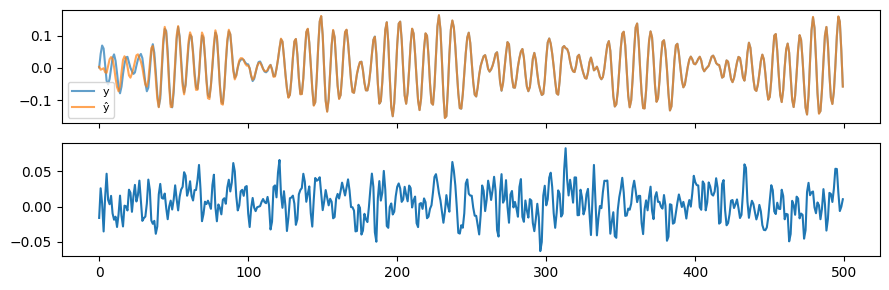

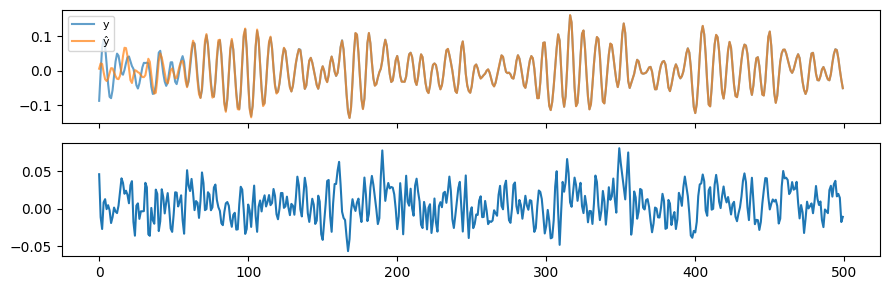

In [4]:
lrn_lstm.show_results(max_n=2)

## GRU

Gated Recurrent Unit: similar to LSTM but with a simpler gating mechanism
(2 gates instead of 3). The update gate and reset gate combine the roles of
LSTM's input, forget, and output gates. GRUs often train faster than LSTMs
with comparable performance on many tasks.

In [5]:
lrn_gru = RNNLearner(dls, rnn_type='gru', hidden_size=40, metrics=[fun_rmse])
lrn_gru.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.006627,0.004971,0.011429,00:03
1,0.004631,0.005058,0.010881,00:02
2,0.004458,0.005631,0.010954,00:02
3,0.004023,0.003797,0.010125,00:02
4,0.004363,0.004099,0.010138,00:03
5,0.004615,0.008112,0.012456,00:03
6,0.003868,0.004119,0.010148,00:03
7,0.004195,0.003956,0.010033,00:03
8,0.003355,0.003062,0.009785,00:03
9,0.002800,0.002941,0.009758,00:03


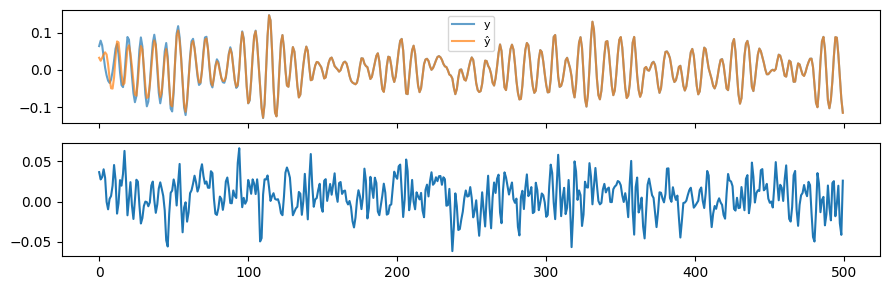

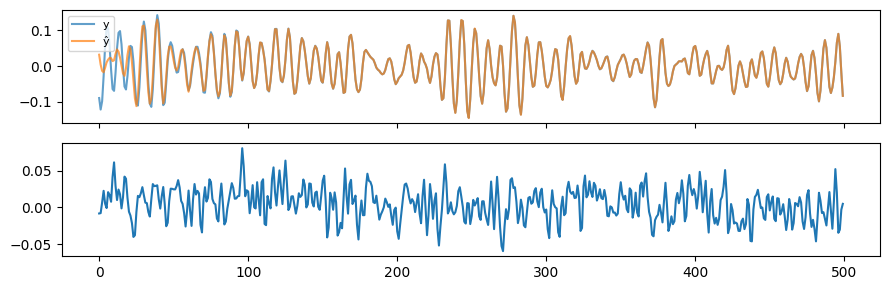

In [6]:
lrn_gru.show_results(max_n=2)

## TCN (Temporal Convolutional Network)

TCNs use 1D causal convolutions with exponentially increasing dilation factors.
Each layer doubles the dilation (1, 2, 4, 8, ...), so the receptive field grows
as 2^depth. Unlike RNNs, TCNs process the entire sequence in parallel, making
them significantly faster to train on GPUs.

Key parameters:

- **`num_layers=4`** -- number of TCN blocks. Controls the receptive field
  (2^4 = 16 timesteps). Deeper networks see further back in time.
- **`hidden_size=40`** -- number of channels (feature maps) per layer.
  Controls the width of the network.

In [7]:
lrn_tcn = TCNLearner(dls, num_layers=4, hidden_size=40, metrics=[fun_rmse])
lrn_tcn.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.025585,0.025140,0.031501,00:04
1,0.024917,0.024545,0.030771,00:04
2,0.024598,0.024722,0.030998,00:04
3,0.024501,0.024526,0.030752,00:04
4,0.024311,0.024423,0.030580,00:04
5,0.024238,0.024372,0.030542,00:04
6,0.024306,0.024765,0.031038,00:04
7,0.024217,0.024297,0.030456,00:04
8,0.023968,0.024285,0.030403,00:04
9,0.023780,0.024237,0.030346,00:04


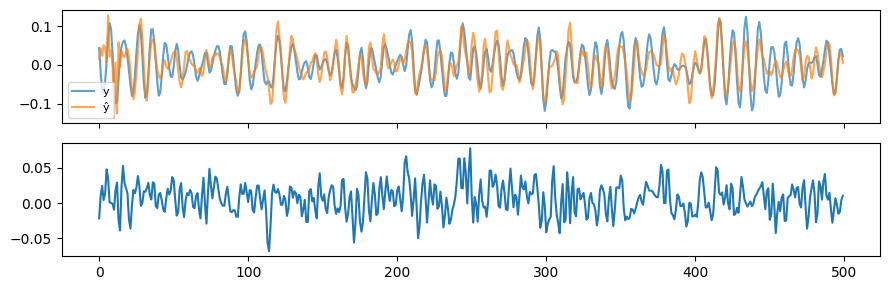

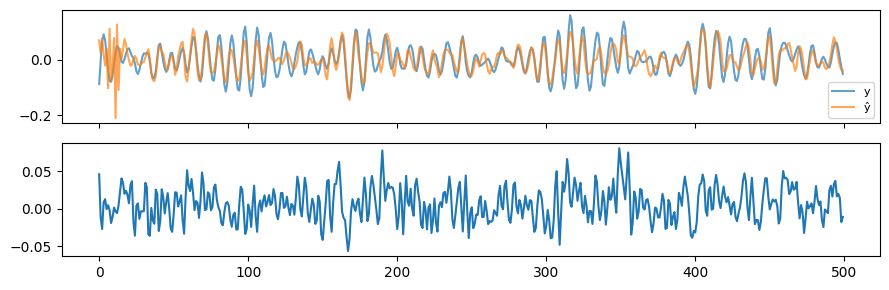

In [8]:
lrn_tcn.show_results(max_n=2)

## CRNN (Convolutional Recurrent Neural Network)

The CRNN combines a TCN front-end with an RNN back-end. The convolutional
layers extract local temporal features (patterns, transients) efficiently in
parallel, then the RNN captures long-range dynamics and sequential
dependencies. This hybrid approach can outperform either architecture alone.

Key parameters:

- **`num_cnn_layers=4`** -- depth of the TCN feature extractor
- **`num_rnn_layers=1`** -- depth of the RNN sequential modeler

In [9]:
lrn_crnn = CRNNLearner(dls, num_cnn_layers=4, num_rnn_layers=1, metrics=[fun_rmse])
lrn_crnn.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.024451,0.023754,0.029867,00:05
1,0.009545,0.008986,0.013869,00:04
2,0.006866,0.006512,0.011725,00:04
3,0.006099,0.005581,0.010913,00:04
4,0.005821,0.005192,0.010591,00:05
5,0.005628,0.006681,0.011297,00:05
6,0.004736,0.004405,0.010079,00:04
7,0.004828,0.006677,0.011355,00:04
8,0.003677,0.003714,0.009798,00:04
9,0.003365,0.003574,0.009803,00:04


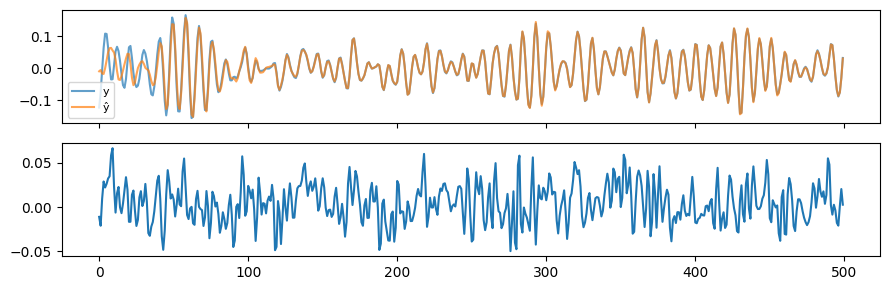

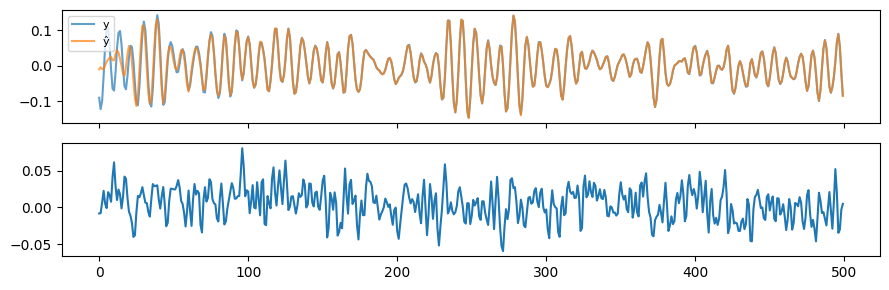

In [10]:
lrn_crnn.show_results(max_n=2)

## Comparison

Let's compare the final validation loss and RMSE across all four models.

In [11]:
results = {
    'LSTM': lrn_lstm.validate(),
    'GRU': lrn_gru.validate(),
    'TCN': lrn_tcn.validate(),
    'CRNN': lrn_crnn.validate(),
}
for name, val in results.items():
    print(f"{name:6s}: loss={val[0]:.4f}, RMSE={val[1]:.4f}")

LSTM  : loss=0.0029, RMSE=0.0096
GRU   : loss=0.0029, RMSE=0.0098
TCN   : loss=0.0242, RMSE=0.0303
CRNN  : loss=0.0036, RMSE=0.0098


## Trade-offs

**TCN**

- Parallel computation makes training fast, especially on GPUs.
- Fixed receptive field (2^depth) may miss very long-range dependencies unless
  you add enough layers.
- Good default choice for many problems -- fast to train with strong
  performance.

**RNN (LSTM / GRU)**

- Sequential processing is inherently slower than parallel convolutions.
- Flexible memory allows learning arbitrarily long dependencies in principle.
- GRU is simpler than LSTM (fewer parameters), often sufficient for moderate
  complexity systems.
- LSTM's explicit cell state can help when the system has very long memory.

**CRNN**

- Best of both worlds: the CNN extracts local features efficiently, the RNN
  models long-range dynamics.
- More hyperparameters to tune (CNN depth, RNN depth, hidden sizes for each
  stage).
- Can be the strongest choice when you have compute budget for tuning.

## Key Takeaways

- **LSTM and GRU** process sequences step-by-step. GRU is simpler and often
  trains faster; LSTM has more capacity for complex dynamics.
- **TCN** processes sequences in parallel via causal convolutions. Fast to
  train, with receptive field controlled by network depth.
- **CRNN** combines CNN feature extraction with RNN sequential modeling,
  offering a flexible hybrid architecture.
- All architectures are accessed through the same simple API:
  `RNNLearner`, `TCNLearner`, `CRNNLearner`.
- Start with TCN or GRU as a baseline, then try CRNN if you need more
  capacity.